In [1]:
# use a pretrained network
# if the original dataset is large enough and general enough,
# then the spatial hierarchy of features learned
# by the pretrained network can effectively act as a generic model of the visual world,
# and hence its features can prove useful for many different computer-vision problems,
# even though these new problems may involve completely different classes
# than those of the original task.

In [2]:
# there are two ways to use a pretrained network:
# feature extraction and fine-tuning
# data augmentatuon discuss:
# https://stats.stackexchange.com/q/331162

In [3]:
# feature extraction

In [4]:
from keras.applications import VGG16


conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

2022-07-27 04:14:49.938370: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-27 04:14:49.941180: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [5]:
# there are two ways you could proceed
# recording the output of conv_base on your data and using these outputs as inputs to a new model
# extending the model by adding Dense layer on top

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


base_dir = '/root/workspace/ml/dogs-vs-cats'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20


def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels


train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(test_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 239ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 211ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 234ms/step


In [7]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [8]:
# Defining and training the densely connected classifier

from keras import models
from keras import layers
from keras import optimizers


model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

/usr/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/30
100/100 [==============================] - 5s 46ms/step - loss: 0.5760 - acc: 0.6860 - val_loss: 0.4363 - val_acc: 0.8280
Epoch 2/30
100/100 [==============================] - 6s 60ms/step - loss: 0.4159 - acc: 0.8230 - val_loss: 0.3622 - val_acc: 0.8440
Epoch 3/30
100/100 [==============================] - 7s 66ms/step - loss: 0.3479 - acc: 0.8455 - val_loss: 0.3336 - val_acc: 0.8610
Epoch 4/30
100/100 [==============================] - 7s 68ms/step - loss: 0.3117 - acc: 0.8780 - val_loss: 0.3098 - val_acc: 0.8650
Epoch 5/30
100/100 [==============================] - 7s 66ms/step - loss: 0.2890 - acc: 0.8815 - val_loss: 0.3008 - val_acc: 0.8700
Epoch 6/30
100/100 [==============================] - 6s 57ms/step - loss: 0.2650 - acc: 0.9030 - val_loss: 0.2881 - val_acc: 0.8770
Epoch 7/30
100/100 [==============================] - 4s 41ms/step - loss: 0.2439 - acc: 0.9015 - val_loss: 0.2791 - val_acc: 0.8810
Epoch 8/30
100/100 [==============================] - 4s 44ms/step - 

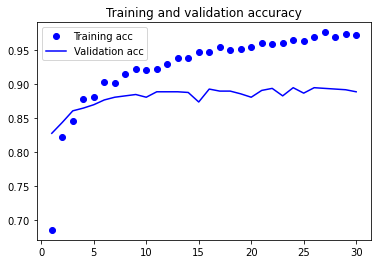

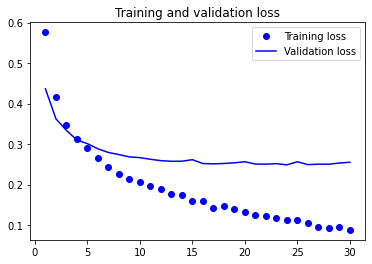

In [9]:
import matplotlib.pyplot as plt


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [10]:
# models behave just like layers,
# you can add a model to a Sequential model just like you would add a layer

from keras import models
from keras import layers


model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [11]:
print('This is the number of trainable weights before freezing the conv base:',
      len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:',
      len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=20, 
    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150, 150), 
    batch_size=20, 
    class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30


/usr/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/tmp/ipykernel_170234/2026648923.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 [==============================] - 50s 494ms/step - loss: 0.5917 - acc: 0.6915 - val_loss: 0.4647 - val_acc: 0.8050
Epoch 2/30
100/100 [==============================] - 48s 477ms/step - loss: 0.4858 - acc: 0.7795 - val_loss: 0.3709 - val_acc: 0.8520
Epoch 3/30
100/100 [==============================] - 50s 497ms/step - loss: 0.4345 - acc: 0.8105 - val_loss: 0.3306 - val_acc: 0.8680
Epoch 4/30
100/100 [==============================] - 50s 498ms/step - loss: 0.3999 - acc: 0.8195 - val_loss: 0.3079 - val_acc: 0.8750
Epoch 5/30
100/100 [==============================] - 50s 498ms/step - loss: 0.3854 - acc: 0.8305 - val_loss: 0.2925 - val_acc: 0.8830
Epoch 6/30
100/100 [==============================] - 48s 482ms/step - loss: 0.3676 - acc: 0.8420 - val_loss: 0.2839 - val_acc: 0.8820
Epoch 7/30
100/100 [==============================] - 47s 473ms/step - loss: 0.3584 - acc: 0.8515 - val_loss: 0.2868 - val_acc: 0.8700
Epoch 8/30
100/100 [==============================] - 49s 494ms/st

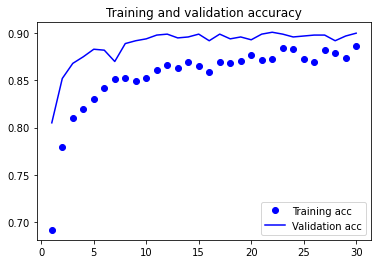

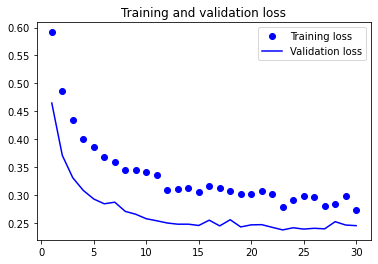

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [14]:
# fine-tuning

# consists of unfreezing a few of the top layers of a frozen model base used for feature extraction,
# and joinly training batch the newly added part of the model and these top layers.

In [15]:
# it's only possible to fine-tune the top layers of the convolutional base
# once the clssifier on top has already beeb trained.
# if the classifier isn't already trained,
# then the error signal propagating through the network during training will be too large,
# and the representations previously learned by the layers being fine-tuned will be destroyed.
# thus the steps for fine-tuning a network are as follow:
# - add your custom network on top of an already-trained base network
# - freeze the base network
# - train the part you added
# - unfreeze some layers in the base network
# - jointly train both these layers and the part you added

In [16]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100


/tmp/ipykernel_170234/4075858126.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 [==============================] - 58s 568ms/step - loss: 0.2915 - acc: 0.8720 - val_loss: 0.2321 - val_acc: 0.9070
Epoch 2/100
100/100 [==============================] - 56s 563ms/step - loss: 0.2587 - acc: 0.8930 - val_loss: 0.2522 - val_acc: 0.8990
Epoch 3/100
100/100 [==============================] - 59s 589ms/step - loss: 0.2216 - acc: 0.9045 - val_loss: 0.2131 - val_acc: 0.9210
Epoch 4/100
100/100 [==============================] - 58s 577ms/step - loss: 0.2194 - acc: 0.9120 - val_loss: 0.2015 - val_acc: 0.9220
Epoch 5/100
100/100 [==============================] - 57s 575ms/step - loss: 0.2155 - acc: 0.9115 - val_loss: 0.1989 - val_acc: 0.9270
Epoch 6/100
100/100 [==============================] - 56s 562ms/step - loss: 0.1908 - acc: 0.9190 - val_loss: 0.2023 - val_acc: 0.9240
Epoch 7/100
100/100 [==============================] - 56s 560ms/step - loss: 0.1888 - acc: 0.9225 - val_loss: 0.1909 - val_acc: 0.9300
Epoch 8/100
100/100 [==============================] - 57s 5

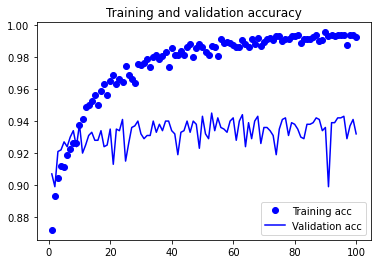

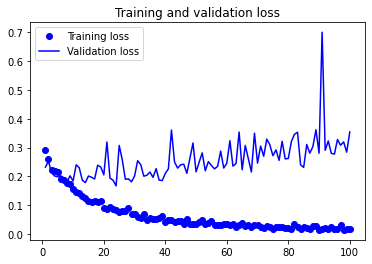

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

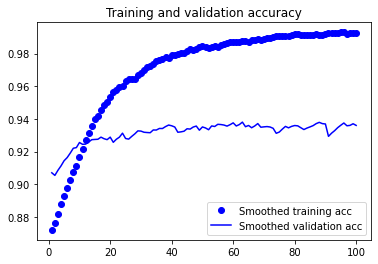

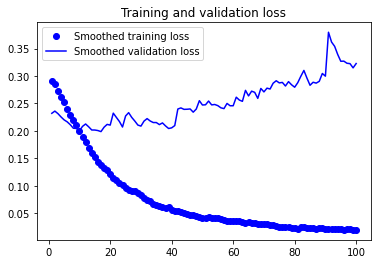

In [19]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [22]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


/tmp/ipykernel_170234/2505688056.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)


test acc: 0.9319999814033508
